In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.model = nn.Sequential(
                        nn.Linear(784, 512),
                      nn.ReLU(),
                      nn.Linear(512, 10),
                      nn.LogSoftmax(dim=1))

    def forward(self, x):
        x = x.view(x.shape[0], -1) # means give the number of rows, infer the columns
        x = self.model(x)
        output = F.log_softmax(x)
        return output
    

In [3]:
MAX_EPOCH=15
def returnLossPredictedOp(model, train_dataloader, val_dataloader):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    
    # training loop
    train_loss_list = list()
    val_loss_list = list()
    train_weights_3_epochs_alllayer=[]
    train_weights_3_epochs_layer1=[]
    for epoch in range(MAX_EPOCH):
        model.train()
        # training loop
        temp_loss_list = list()
        for X_train, y_train in train_dataloader:
            X_train = X_train.type(torch.float32).to(device)
            y_train = y_train.type(torch.LongTensor).to(device)

            optimizer.zero_grad()

            score = model(X_train)

            loss = criterion(score,y_train)
            #loss.requires_grad = True
            loss.backward()

            optimizer.step()

            temp_loss_list.append(loss.detach().cpu().numpy())

        train_loss_list.append(np.average(temp_loss_list))
        if epoch%3==0:
            train_weights_3_epochs_alllayer.append(torch.cat((torch.flatten(model.model[0].weight), 
                                                torch.flatten(model.model[2].weight)), dim=0))
            train_weights_3_epochs_layer1.append(model.model[0].weight)
        # validation
        model.eval()

        temp_loss_list = list()

        for X_val, y_val in val_dataloader:
            X_val = X_val.type(torch.float32).to(device)
            y_val = y_val.type(torch.LongTensor).to(device)

            score = model(X_val)        
            loss = criterion(input=score, target=y_val)

            temp_loss_list.append(loss.detach().cpu().numpy())

        val_loss_list.append(np.average(temp_loss_list))
    
    return train_loss_list, val_loss_list, train_weights_3_epochs_layer1, train_weights_3_epochs_alllayer





In [4]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)

device = torch.device("cuda" if use_cuda else "cpu")

train_kwargs = {'batch_size': 512}
test_kwargs = {'batch_size': 512}
if use_cuda:
    cuda_kwargs = {'num_workers': 1,
                   'pin_memory': True,
                   'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

transform=transforms.Compose([
        transforms.ToTensor()
        #transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [5]:
model = Net().to(device)
summary(model,(1 ,28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
              ReLU-2                  [-1, 512]               0
            Linear-3                   [-1, 10]           5,130
        LogSoftmax-4                   [-1, 10]               0
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


/var/folders/t1/bvs3thn144vgkyf7lpstqsb40000gn/T/ipykernel_33037/811349288.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


In [9]:

t_loss=[]
v_loss=[]
layer1_weights=[]
total_weights=[]
for i in range(8):
    model1 = Net()
    t_ls_1, v_ls_1, lyr1_weights, tot_weights = returnLossPredictedOp(model1, train_loader, test_loader)
    t_loss = t_ls_1
    v_loss = v_ls_1
    layer1_weights = layer1_weights+lyr1_weights
    total_weights = total_weights+tot_weights
    

/var/folders/t1/bvs3thn144vgkyf7lpstqsb40000gn/T/ipykernel_3116/811349288.py:13: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


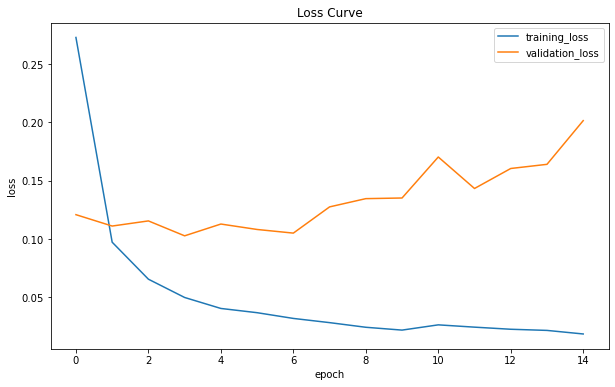

In [92]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
plt1=plt.figure(figsize=(10, 6))
plt.plot(np.array(t_ls_1) ,  label='training_loss')
plt.plot(np.array(v_ls_1) ,  label='validation_loss')

plt.xlabel('epoch')
plt.ylabel('loss') 
plt.legend()
plt.title("Loss Curve")
plt.show()


In [117]:
dataMatrix1 = np.array([total_weights[i].detach().numpy() for i in range(len(total_weights))])
first_layer = np.array([layer1_weights[i].detach().numpy() for i in range(len(layer1_weights))])
first_layer_flat=first_layer.reshape(first_layer.shape[0]*first_layer.shape[1], first_layer.shape[2])

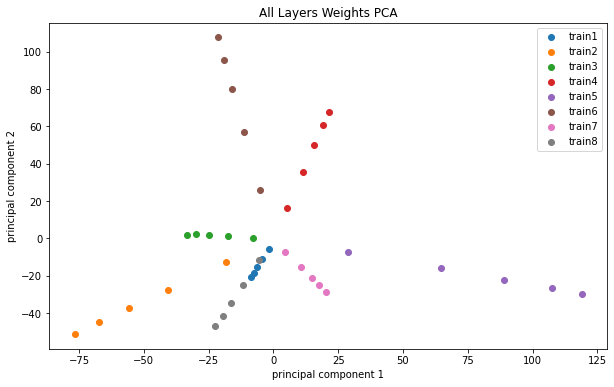

In [122]:
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt


pca = PCA(n_components=2)
plt1=plt.figure(figsize=(10, 6))
principalComponents = pca.fit_transform(dataMatrix1)
pca1=np.array(principalDf['principal component 1'])
pca2=np.array(principalDf['principal component 2'])
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
plt.scatter(pca1[:5],pca2[:5] ,  label='train1')
plt.scatter(pca1[5:10],pca2[5:10] ,  label='train2')
plt.scatter(pca1[10:15],pca2[10:15] ,  label='train3')
plt.scatter(pca1[15:20],pca2[15:20] ,  label='train4')
plt.scatter(pca1[20:25],pca2[20:25] ,  label='train5')
plt.scatter(pca1[25:30],pca2[25:30] ,  label='train6')
plt.scatter(pca1[30:35],pca2[30:35] ,  label='train7')
plt.scatter(pca1[35:40],pca2[35:40] ,  label='train8')

plt.xlabel('principal component 1')
plt.ylabel('principal component 2') 
plt.legend()
plt.title("All Layers Weights PCA")
plt.show()

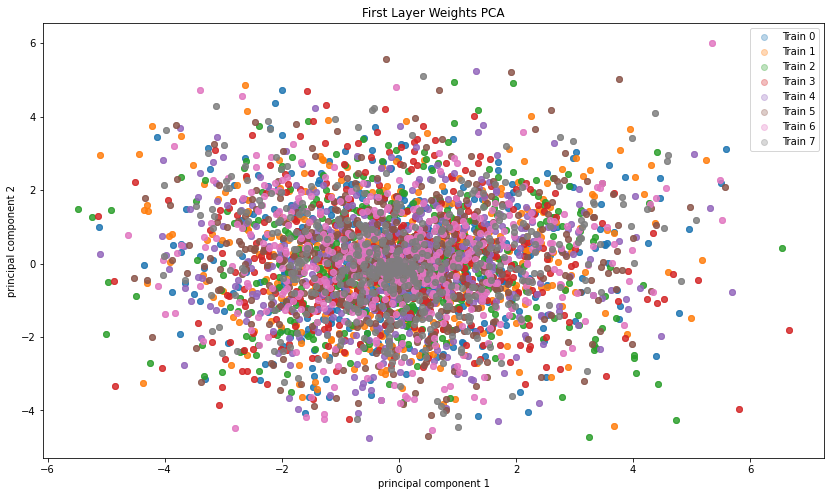

In [120]:

from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

plt1=plt.figure(figsize=(14, 8))
pca = PCA(n_components=2)
count=0
for i in range(0, len(first_layer_flat), 2560):
    principalComponents = pca.fit_transform(first_layer_flat[i:i+2560])
    principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
    plt.scatter(np.array(principalDf['principal component 1']), np.array(principalDf['principal component 2']), alpha=0.3 , label='Train {}'.format(count))
    count+=1
plt.xlabel('principal component 1')
plt.ylabel('principal component 2') 
plt.legend()
plt.title("First Layer Weights PCA")
plt.show()
